In [1]:
import numpy as np
import pandas as pd
import cv2  #package for image display
import pickle
from random import shuffle
from matplotlib import pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#load libraries needed fOR CNN
from vgg16 import VGG16
import numpy as np
import argparse
import cv2

from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from keras.optimizers import SGD
from keras import backend as K
from keras import applications
from keras import optimizers
from keras.models import Model
from keras.callbacks import TensorBoard
from keras.preprocessing import image as image_utils
from imagenet_utils import decode_predictions
from imagenet_utils import preprocess_input

import h5py

Using TensorFlow backend.


In [3]:
# read the data
data = pd.read_csv("add_imdb_utf8_fixruntime_cleaned.csv")
data.shape

# extract movies with poster information
index = np.zeros(data.shape[0])

for i in range(data.shape[0]):
    try:
        np.isnan(data.iloc[i, 0])
    except:
        index[i] = 1
        
print ("There are {} movies without poster.".format(np.sum(index == 0)))

# extract data with poster
data_with_poster = data.iloc[index == 1, ]
print ("Final data dimension:")
data_with_poster.shape

There are 103 movies without poster.
Final data dimension:


(5893, 39)

In [4]:
###### read each image and resize 

# total number of posters
n = data_with_poster.shape[0]

# target image size
target_length = 180
target_width = 128

# np.array to store the whole matrix in the order of the movie id
img_matrix = np.zeros([n, target_length, target_width, 3])

for i in range(n):
    if i % 1000 == 0:    
        print (i)    
    
    movie_id = data_with_poster["id"].values[i]
    
    path = 'posters_2011_2016/' + str(movie_id) + '.jpg'
    
    # read image
    img = cv2.imread(path)
    
    # normalize the image[-1,1], center at 0
    # so that the zero padding does not affect the image
    img = img.astype('float32')
    img = (img - 255/2)/255
    
    # extract the length and width of the image
    img_length, img_width = np.asarray(img.shape[:2])

    
    ## put the image to the center of the array
    # calcuate location of the left edge
    left_loc = int(0.5*(target_width - img_width))
    # calcuate location of the top edge
    top_loc = int(0.5*(target_length - img_length))
    
    # store the image
    img_matrix[i, top_loc:(top_loc+img_length), 
               left_loc:(left_loc+img_width), :] = img
    
print ("Final data shape:")
img_matrix.shape

0
1000
2000
3000
4000
5000
Final data shape:


(5893, 180, 128, 3)

In [5]:
# reformat the data shape
if K.image_data_format() == 'channels_first':
    img_matrix = img_matrix.reshape(n, 3, target_length, target_width)
    input_shape = (3, target_length, target_width)
else:
    img_matrix = img_matrix.reshape(n, target_length, target_width, 3)
    input_shape = (target_length, target_width, 3)

print('data shape:', img_matrix.shape)

data shape: (5893, 180, 128, 3)


In [6]:
### extract and clean the response variable 
# convert genre ids to list
y = list()
for i in range(data_with_poster.shape[0]):
    genre = map(int, re.sub("[\[ \] ]", "", data['genre_ids'][i]).split(','))
    y.append(genre)

# binarize response variable (returns array)
y_binary = MultiLabelBinarizer().fit_transform(y)
num_classes = 20

In [7]:
### split the train and test data
# shuffle the samples
seed = 109
index_2 = range(n)
shuffle(index_2)

img_matrix = img_matrix[index_2]
y_binary = y_binary[index_2]

# use the training data to fit the model
split_ratio = 0.9
split_num = int(n * split_ratio)

x_train = img_matrix[:split_num]
x_test = img_matrix[split_num:]

y_train = y_binary[:split_num]
y_test = y_binary[split_num:]

In [8]:
#load pretrained model - VGG16
base_model =VGG16(weights='imagenet', include_top=False)

# set the first 15 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in base_model.layers:
    layer.trainable = False

In [9]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [10]:
# pass the data through the base_model
x_train_base = base_model.predict(x_train)
x_test_base = base_model.predict(x_test)

In [11]:
x_train_base.shape

(5303, 5, 4, 512)

In [12]:
# create an empty network model
model = Sequential()

# --- input layer ---
model.add(GlobalAveragePooling2D(input_shape=x_train_base.shape[1:]))

# --- fully connected layer ---
model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.3))
# --- classification ---
model.add(Dense(num_classes, activation='sigmoid'))

# prints out a summary of the model architecture
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1300      
Total params: 34,132.0
Trainable params: 34,132.0
Non-trainable params: 0.0
_________________________________________________________________


In [13]:
sgd = SGD(lr=0.00005, momentum=0.9)
model.compile(loss='binary_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [14]:
# specify the tuning parameters
# smaller batch size means noisier gradient, but more updates per epoch
batch_size = 20
# number of iterations over the complete training data
epochs = 1000
# add early stopping
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')

In [15]:
history = model.fit(x_train_base, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[earlyStopping],
                    validation_split=0.1)

Train on 4772 samples, validate on 531 samples
Epoch 1/1000
4772/4772 [==============================] - 0s - loss: 0.6281 - acc: 0.6782 - val_loss: 0.6014 - val_acc: 0.7150

(0, 70)

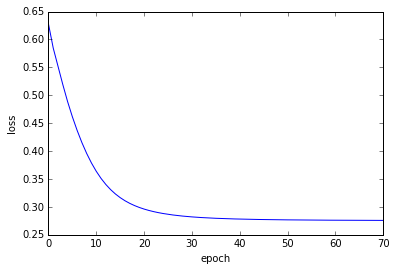

In [19]:
plt.plot(history.history['loss'])
plt.xlabel("epoch")
plt.ylabel("loss")
plt.xlim(0, 70)

(0, 70)

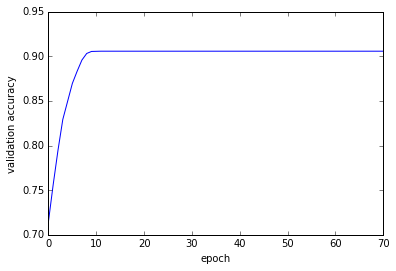

In [21]:
plt.plot(history.history['val_acc'])
plt.xlabel("epoch")
plt.ylabel("validation accuracy")
plt.xlim(0, 70)

(0, 70)

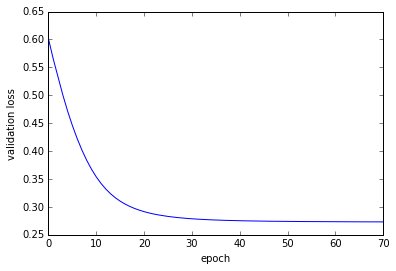

In [23]:
plt.plot(history.history['val_loss'])
plt.xlabel("epoch")
plt.ylabel("validation loss")
plt.xlim(0, 70)

In [102]:
y_pred = model.predict(x_test)

In [24]:
model.save('finetune_face_sgd_0.00005.h5')